# Задача 7. Нейронные сети

## Задача

- [ ] Найти данные в виде изображений для задачи классификации.
- [ ] Реализовать классы, необходимые для построения сети со следующими слоями
	- FullyConnectedLayer
	- ReluLayer
	- FullyConnectedLayer
- [ ] Использовать CrossEntropyLoss и L2-регуляризацию.
- [ ] Обучить модель на тренировочных данных, подбирать параметры (особенно learning rate) на валидационной и оценить качество на тестовой. Анализировать графики train/val loss, проверять на каждом шаге корректность вычисления градиентов с помощью разностной оценки.
- [ ] * (**+2 балла**) Добавить Batch normalization.
- [ ] * (**+2 балла**) В качестве оптимизатор использовать один из: Momentum, RMSprop.
- [ ] * (**+1 балл**) Также реализовать оптимизатор Adam.

## Датасет

[Butterfly Image Classification](https://www.kaggle.com/datasets/phucthaiv02/butterfly-image-classification) — содержит более 10 000 изображений 75 различных видов бабочек.

Каждое изображение имеет размер 224x224 пикселя. Класс каждого изображения хранится в файле Training_set.csv.

In [1]:
import kagglehub
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from utils import MyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

2025-03-27 12:20:28.364788: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-27 12:20:28.391242: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-27 12:20:28.584900: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-27 12:20:28.740198: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743067228.885997   30765 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743067228.92

In [2]:
folder = kagglehub.dataset_download("phucthaiv02/butterfly-image-classification")
training_set_path = os.path.join(folder, "Training_set.csv")

df = pd.read_csv(training_set_path)

df.head(5)

,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART


Для обучения нейронной сети выберем несколько самых распространенных в датасете картинок (так как 72 может быть слишком много).

In [3]:
class_counts = df["label"].value_counts().sort_values(ascending=False)

most_popular_classes = list(class_counts[:10].index)

df = df[df["label"].isin(most_popular_classes)]

print("Current size is:", df.size)
df.head(5)

Current size is: 2032


,filename,label
2,Image_3.jpg,BROWN SIPROETA
8,Image_9.jpg,BROWN SIPROETA
29,Image_30.jpg,ATALA
44,Image_45.jpg,RED CRACKER
52,Image_53.jpg,SCARCE SWALLOW


In [4]:
train_img_folder = os.path.join(folder, "train")


def load_image(filename):
    img_path = os.path.join(train_img_folder, filename)
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    return img.ravel()


df["image"] = df["filename"].apply(load_image)

df.head(3)

,filename,label,image
2,Image_3.jpg,BROWN SIPROETA,"[0.9254902, 0.9098039, 0.8980392, 0.9254902, 0..."
8,Image_9.jpg,BROWN SIPROETA,"[0.25882354, 0.43137255, 0.12156863, 0.2509804..."
29,Image_30.jpg,ATALA,"[0.7254902, 0.5803922, 0.3647059, 0.8039216, 0..."


## Запуск алгоритма

Для первого (пробного) запуска выберем случайные параметры, чтобы убедиться, что удаётся получить хотя бы немного корректный результат. 

In [5]:
input_num = 224 * 224 * 3
classes_num = len(most_popular_classes)
i = 512

print(
    f"Create classifier with such params:\
    \n- Input neurons: {input_num}\
    \n- Classes: {classes_num}\
    \n- Hidden neurons: {i}"
)

classifier = MyClassifier(input_num, classes_num, i)

Create classifier with such params:    
- Input neurons: 150528    
- Classes: 10    
- Hidden neurons: 512


Разделим датасет на тренировочный и тестовый, а также нормализуем его для обучения:

In [6]:
X = np.stack(df["image"].to_numpy())
labels = df["label"].to_numpy()

label_mapping = {label: idx for idx, label in enumerate(np.unique(labels))}
y = np.array([label_mapping[label] for label in labels])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Теперь запустим сам алгоритм:

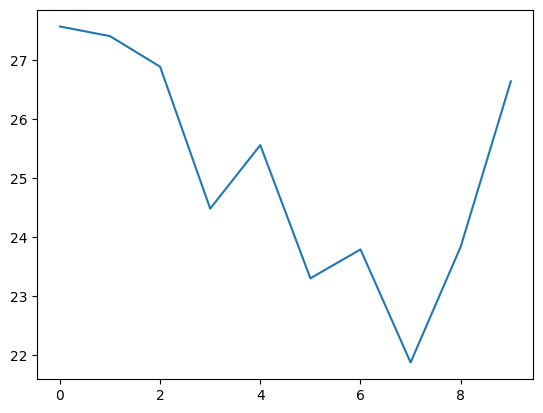

In [7]:
loss_values = classifier.fit(X_train, y_train, learning_rate=0.0001, epochs=10)

plt.plot(loss_values)

In [8]:
y_pred = classifier.predict_max(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(accuracy)

0.29901960784313725


Исходя из значения *accuracy*, можно сделать вывод, что модель обучилась и смогла выдать результат лучше, чем при простом угадывании (0.1). Теперь можно попробовать подобрать оптимальные параметры обучения и сравнить результат. 

## Подбор параметров

Количество нейронов в скрытом слое:

In [15]:
def param_fit(
    hidden_neurons_num=512, batch_size=100, learning_rate=0.0001, reg=0.00001
):
    classifier = MyClassifier(input_num, classes_num, hidden_neurons_num)

    loss_values = classifier.fit(
        X_train, y_train, batch_size, learning_rate, reg=reg, epochs=30
    )

    y_pred = classifier.predict_max(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy, loss_values


In [10]:
hidden_neurons_num_list = [512, 256, 128, 64]

accuracies = []

for i in hidden_neurons_num_list:
    accuracy, loss_values = param_fit(hidden_neurons_num=i)
    accuracies.append(accuracy)

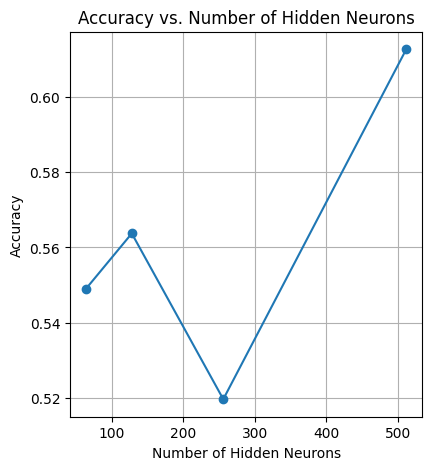

In [11]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(hidden_neurons_num_list, accuracies, marker="o", linestyle="-")
plt.xlabel("Number of Hidden Neurons")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Number of Hidden Neurons")
plt.grid(True)

Будем считать оптимальным числом нейронов 512, так как большие значения проверить нет возможности.

Теперь определимся с параметром *batch_size*:

In [12]:
batch_size_list = [100, 200, 300, 400, 500, 1000]

accuracies = []

for i in batch_size_list:
    accuracy, loss_values = param_fit(batch_size=i)
    accuracies.append(accuracy)

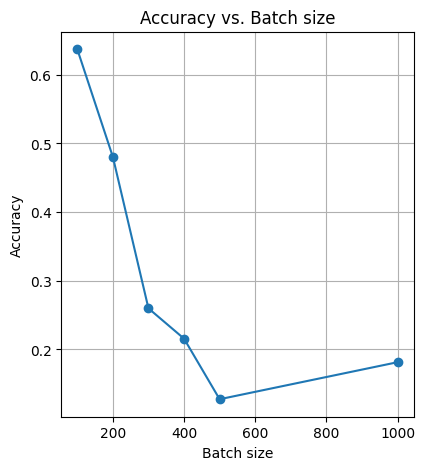

In [14]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(batch_size_list, accuracies, marker="o", linestyle="-")
plt.xlabel("Batch size")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Batch size")
plt.grid(True)

Теперь подберём параметр *reg*:

In [ ]:
reg_list = [1.0, 0.5, 0.1, 0.15, 0.01, 0.001, 0.0001, 0.00001]

accuracies = []

for i in reg_list:
    accuracy, loss_values = param_fit(reg=i)
    accuracies.append(accuracy)

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(reg_list, accuracies, marker="o", linestyle="-")
plt.xlabel("Reg")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Reg const")
plt.grid(True)

И, наконец, подберём *learning rate*:

In [ ]:
learning_rate_list = [1.0, 0.5, 0.1, 0.15, 0.01, 0.001, 0.0001, 0.00001]

accuracies = []

for i in learning_rate_list:
    accuracy, loss_values = param_fit(learning_rate=i)
    accuracies.append(accuracy)

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(learning_rate_list, accuracies, marker="o", linestyle="-")
plt.xlabel("Learning rate")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Learning rate")
plt.grid(True)